# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import re

# Handle miss values and categorical data

In [2]:
TrainData=pd.read_csv("train_submissions.csv")
TrainData['user_id'] = TrainData['user_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)
TrainData['problem_id'] = TrainData['problem_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)

In [3]:
UserData=pd.read_csv("user_data.csv")
UserData['user_id'] = UserData['user_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)
UserData['country'] = UserData['country'].astype('category')
UserData['country'] = UserData['country'].cat.codes #miss value is 0
UserData['country']=UserData['country'].replace(-1,0)#miss value replace with 0
UserData["contribution"]=(UserData["contribution"]-UserData["contribution"].min())/UserData["contribution"].max()
UserData["rank"]=UserData["rank"].replace(['beginner','intermediate','advanced','expert'],[1,2,3,4])
#UserData['last_online_time_hours']=UserData['last_online_time_seconds']/3600
#UserData['registration_time_hours']=UserData['registration_time_seconds']/3600
UserData['last_online_time_seconds']=(UserData['last_online_time_seconds']-UserData['last_online_time_seconds'].min())/(UserData['last_online_time_seconds'].max()-UserData['last_online_time_seconds'].min())
UserData['registration_time_seconds']=(UserData['registration_time_seconds']-UserData['registration_time_seconds'].min())/(UserData['registration_time_seconds'].max()-UserData['registration_time_seconds'].min())
#UserData=UserData.drop('last_online_time_seconds',axis=1)
#UserData=UserData.drop('registration_time_seconds',axis=1)

In [157]:
ProblemData=pd.read_csv("problem_data.csv")
ProblemData['problem_id'] = ProblemData['problem_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)
ProblemData=ProblemData.drop("tags", axis=1)
ProblemData.fillna(ProblemData.mean(), inplace=True)
ProblemData.dropna(inplace=True)
ProblemData["level_type"]=ProblemData["level_type"].replace(['A' ,"B","C","D","E","F","G","H","I","J","K","L","M","N"],
                                                           [ 1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ProblemData['points']=(ProblemData['points']-ProblemData['points'].min())/(ProblemData['points'].max()-ProblemData['points'].min())

In [158]:
df=TrainData.set_index('problem_id').join(ProblemData.set_index('problem_id'))
df.reset_index(inplace=True)
df=df.set_index('user_id').join(UserData.set_index('user_id'))
df.reset_index(inplace=True)
df.dropna(inplace=True)

# Step1: clustering user data

In [6]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(UserData)

In [7]:
UserData["cluster"]=y_pred
User_clusters=UserData.drop([ 'submission_count', 'problem_solved', 'contribution',
       'country', 'follower_count', 'last_online_time_seconds', 'max_rating',
       'rating', 'rank', 'registration_time_seconds'],axis=1)

# Step2: classification user data and problem data

In [8]:
df0=TrainData.set_index('user_id').join(User_clusters.set_index('user_id'))
df0.reset_index(inplace=True)
df=df0.set_index('problem_id').join(ProblemData.set_index('problem_id'))
df.dropna(inplace=True)

# Feature selection

### 1.SelectKBest

In [45]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = df.drop(["attempts_range"],axis=1)  #independent columns
y = df["attempts_range"]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=4)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(4,'Score'))  #print 10 best features

        Specs        Score
2  level_type  3677.159487
0     user_id  3540.095351
3      points   343.803399
1     cluster    28.917763


### 2.Feature Importance

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.9036814  0.00458799 0.04621059 0.04552002]


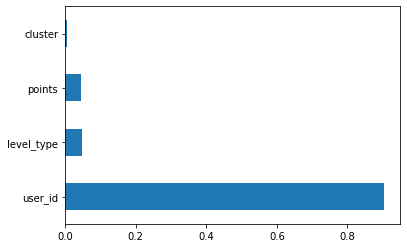

In [46]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(4).plot(kind='barh')
plt.show()

### 3.Correlation Matrix with Heatmap

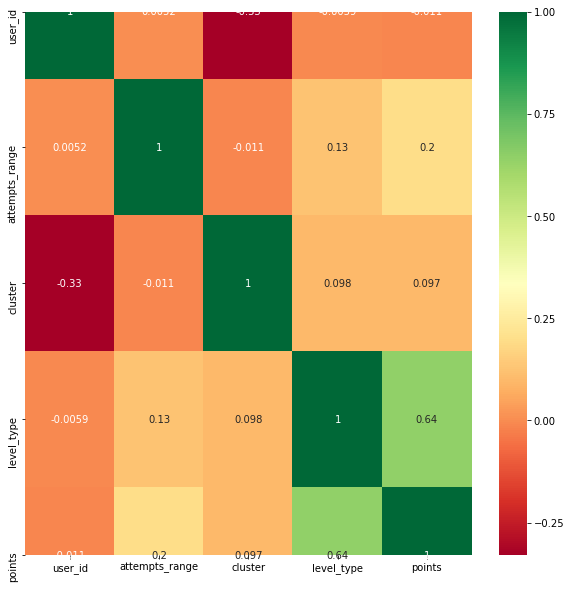

In [48]:
#df=df.drop("user_id",axis=1)
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [49]:
X=df.drop(['attempts_range'],axis=1)

# Multiclass Classification

### 1.SGD Classifer

In [50]:
from sklearn.linear_model import SGDClassifier
sgd_clf1 = SGDClassifier(random_state=42)
sgd_clf1.fit(X, y)

scores1 = sgd_clf1.decision_function(np.array(X.iloc[34500]).reshape(1, -1))
print(scores1)

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf1, X, y, cv=3, scoring="accuracy")

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### 2.Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
forest_clf1 = RandomForestClassifier(random_state=42)
forest_clf1.fit(X, y)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [54]:
forest_clf1.predict_proba(np.array(X.iloc[34500]).reshape(1, -1))

array([[0.65592949, 0.19843559, 0.        , 0.        , 0.14563492,
        0.        ]])

In [55]:
cross_val_score(forest_clf1, X, y, cv=5, scoring="accuracy")

array([0.46669037, 0.4675459 , 0.47499596, 0.47029159, 0.47079171])

# Error Analysis

In [56]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred1 = cross_val_predict(forest_clf1, X, y, cv=3)
conf_mx1 = confusion_matrix(y, y_pred1)
conf_mx1

array([[58548, 18023,  3379,  1242,   537,   747],
       [30033, 12377,  2711,   977,   432,   605],
       [ 8137,  4173,   975,   387,   180,   230],
       [ 2994,  1684,   429,   162,    83,   126],
       [ 1315,   758,   203,   104,    38,    66],
       [ 1543,   915,   277,   127,    69,    89]], dtype=int64)

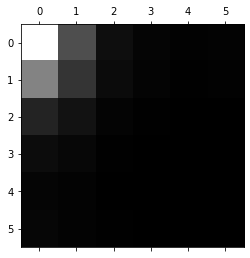

In [57]:
plt.matshow(conf_mx1, cmap=plt.cm.gray)
plt.show()

In [58]:
y_pred3 = cross_val_predict(sgd_clf1, X, y, cv=3)
conf_mx3 = confusion_matrix(y, y_pred3)
conf_mx3

array([[81021,   727,   353,   362,     0,    13],
       [46081,   573,   256,   217,     0,     8],
       [13709,   203,   100,    68,     0,     2],
       [ 5308,    98,    38,    32,     0,     2],
       [ 2402,    46,    21,    15,     0,     0],
       [ 2909,    53,    31,    25,     0,     2]], dtype=int64)

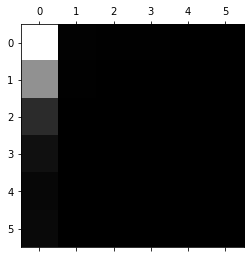

In [59]:
plt.matshow(conf_mx3, cmap=plt.cm.gray)
plt.show()

# Resampling

In [9]:
from sklearn.utils import resample

In [10]:
class6 = df[df.attempts_range==6]
class5 = df[df.attempts_range==5]
class4 = df[df.attempts_range==4]
class3 = df[df.attempts_range==3]
class2 = df[df.attempts_range==2]
class1 = df[df.attempts_range==1]
avr=len(class1)

## (a) Oversampling Minority Class

In [11]:
class6_upsampled = resample(class6,replace=True,n_samples=avr,random_state=27)
class5_upsampled = resample(class5,replace=True,n_samples=avr,random_state=27)
class4_upsampled = resample(class4,replace=True,n_samples=avr,random_state=27)
class3_upsampled = resample(class3,replace=True,n_samples=avr,random_state=27)
class2_upsampled = resample(class3,replace=True,n_samples=avr,random_state=27)
df2= pd.concat([class1,class2_upsampled,class3_upsampled,class4_upsampled,class5_upsampled,class6_upsampled])

### Random Forest

In [12]:
X=df2.drop(['attempts_range'],axis=1)
y=df2["attempts_range"]
from sklearn.ensemble import RandomForestClassifier
forest_clf1 = RandomForestClassifier(random_state=42)
forest_clf1.fit(X, y)

RandomForestClassifier(random_state=42)

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(forest_clf1, X, y, cv=5, scoring="accuracy")

array([0.7536576 , 0.75077548, 0.7533823 , 0.75826252, 0.75323074])

[[ 37455  24721   8458   6373   5469]
 [  4617 130898   9216  11110   9111]
 [  1539  11258  57260   6792   5627]
 [   167   3397   1485  74501   2926]
 [    30   4299   1630   4598  71919]]


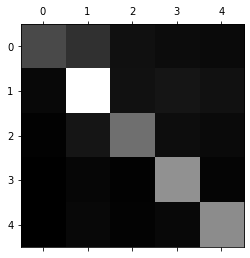

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred1 = cross_val_predict(forest_clf1, X, y, cv=3)
conf_mx1 = confusion_matrix(y, y_pred1)
print(conf_mx1)
plt.matshow(conf_mx1, cmap=plt.cm.gray)
plt.show()

## (b) Undersampling Majority Class

In [22]:
k=len(class5)
class6_undersampled = resample(class6,replace=True,n_samples=k,random_state=27)
class4_undersampled = resample(class4,replace=True,n_samples=k,random_state=27)
class3_undersampled = resample(class3,replace=True,n_samples=k,random_state=27)
class2_undersampled = resample(class3,replace=True,n_samples=k,random_state=27)
class1_undersampled = resample(class1,replace=True,n_samples=k,random_state=27)
df3= pd.concat([class5,class1_undersampled,class2_undersampled,class3_undersampled,class4_undersampled,class6_undersampled])

###  Random forest

In [19]:
X=df3.drop(['attempts_range'],axis=1)
y=df3["attempts_range"]
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X, y)

RandomForestClassifier(random_state=42)

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(forest_clf1, X, y, cv=5, scoring="accuracy")

array([0.53270715, 0.53740356, 0.54142905, 0.52767528, 0.52718121])

[[ 698  701  381  400  304]
 [ 117 4519  136  101   95]
 [ 350  588  897  366  283]
 [ 403  718  434  487  442]
 [ 253  441  269  315 1206]]


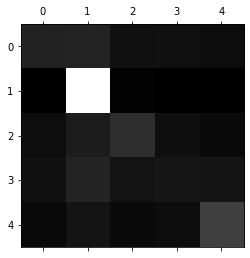

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred1 = cross_val_predict(forest_clf1, X, y, cv=3)
conf_mx1 = confusion_matrix(y, y_pred1)
print(conf_mx1)
plt.matshow(conf_mx1, cmap=plt.cm.gray)
plt.show()

In [24]:
TestData=pd.read_csv("test_submissions.csv")
TestData['user_id'] = TestData['user_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)
TestData['problem_id'] = TestData['problem_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)

In [72]:
TestDf=TestData.set_index('user_id').join(UserData.set_index('user_id'))
TestDf.reset_index(inplace=True)
Test_problem_user_label=TestDf.drop(['ID', 'submission_count', 'problem_solved',
       'contribution', 'country', 'follower_count', 'last_online_time_seconds',
       'max_rating', 'rating', 'rank', 'registration_time_seconds'],axis=1)

In [147]:
DF=Test_problem_user_label.set_index('problem_id').join(ProblemData.set_index('problem_id'))

In [148]:
DF.fillna(ProblemData.mean(), inplace=True)
DF.isnull().sum()

user_id       0
cluster       0
level_type    0
points        0
dtype: int64

In [86]:
X=df2.drop(['attempts_range'],axis=1)
y=df2["attempts_range"]
from sklearn.ensemble import RandomForestClassifier
forest_clf1 = RandomForestClassifier(random_state=42)
forest_clf1.fit(X, y)

RandomForestClassifier(random_state=42)

In [149]:
DF["attempts_range"]=forest_clf1.predict(DF)

In [151]:
DF["user_id"]="user_"+DF["user_id"].astype(str)

In [152]:
DF.reset_index(inplace=True)
DF["problem_id"]="_prob_"+DF["problem_id"].astype(str)

In [153]:
DF["ID"]=DF["user_id"]+DF["problem_id"]

In [154]:
Submission=DF[["ID","attempts_range"]]

In [155]:
Submission.rename(columns={'attemps_range':'attempts_range'},inplace=True)
Submission.to_csv("Submission1.csv")               

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


Finallay i get 0.2955716883 score in analyticsvidhya Leaderboard:((((((